In [1]:
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

sys.path.append('..')
import model_utils as util

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8

In [2]:
DATA_PATH =  '../../../data/cluster/year/'

In [80]:
[[X_train, y_train], 
 [X_valid, y_valid], 
 [X_test, y_test]] = util.load_data(DATA_PATH)

X_train: (529623, 24)
X_valid: (176541, 24)
X_test: (176541, 24)
y_train: (529623, 1)
y_valid: (176541, 1)
y_test: (176541, 1)


In [81]:
interactions = [
    'meanMinTemp_Oct:precip_OctSep', 'precip_meanAnnual:precip_OctSep',
    'precip_OctSep:precipPrevious_OctSep', 'meanTemp_Aug:meanMinTemp_Oct',
    'precip_OctSep:lon', 'precip_OctSep:precip_growingSeason',
    'precip_OctSep:meanMaxTemp_Aug', 'meanMinTemp_Oct:precip_meanAnnual',
    'precip_OctSep:meanTemp_Aug', 'precip_OctSep:meanMinTemp_Oct',
    'precip_OctSep:elev_etopo1', 'precip_OctSep:elev_etopo1',
    'precip_OctSep:lat', 'precip_OctSep:precip_growingSeason',
    'precip_OctSep:precipPrevious_OctSep',
    'precip_OctSep:precip_meanAnnual', 'precip_OctSep:precip_OctSep',
    'meanMaxTemp_Aug:precip_OctSep', 'meanTemp_AprAug:precip_OctSep',
    'precip_OctSep:varPrecip_growingSeason', 'meanTemp_Aug:precip_OctSep',
    'lat:lon', 'lat:elev_etopo1']

In [82]:
X_train = util.make_interactions(X_train, interactions)
X_valid = util.make_interactions(X_valid, interactions)
X_test  = util.make_interactions(X_test, interactions)

In [83]:
X_test_full = X_test.copy()

In [84]:
X_train = X_train.drop(
    ['studyArea', 'x', 'y', 'elev_srtm30', 'year', 
     'varPrecip_growingSeason', 'precip_OctSep:varPrecip_growingSeason'], 
    axis=1)
X_valid = X_valid.drop(
    ['studyArea', 'x', 'y', 'elev_srtm30', 'year', 
     'varPrecip_growingSeason', 'precip_OctSep:varPrecip_growingSeason'], 
    axis=1)
X_test  = X_test.drop(
    ['studyArea', 'x', 'y', 'elev_srtm30', 'year', 
     'varPrecip_growingSeason', 'precip_OctSep:varPrecip_growingSeason'], 
    axis=1)

In [85]:
predictors = list(X_train)
print(predictors)

['meanTemp_Annual', 'meanTemp_AprAug', 'meanTemp_Aug', 'meanMinTemp_DecFeb', 'meanMinTemp_Oct', 'meanMinTemp_Jan', 'meanMinTemp_Mar', 'meanMaxTemp_Aug', 'precip_meanAnnual', 'precip_JunAug', 'vegetation', 'precipPrevious_JunAug', 'precip_OctSep', 'precipPrevious_OctSep', 'precip_growingSeason', 'elev_etopo1', 'lat', 'lon', 'meanMinTemp_Oct:precip_OctSep', 'precip_meanAnnual:precip_OctSep', 'precip_OctSep:precipPrevious_OctSep', 'meanTemp_Aug:meanMinTemp_Oct', 'precip_OctSep:lon', 'precip_OctSep:precip_growingSeason', 'precip_OctSep:meanMaxTemp_Aug', 'meanMinTemp_Oct:precip_meanAnnual', 'precip_OctSep:meanTemp_Aug', 'precip_OctSep:meanMinTemp_Oct', 'precip_OctSep:elev_etopo1', 'precip_OctSep:lat', 'precip_OctSep:precip_meanAnnual', 'precip_OctSep:precip_OctSep', 'meanMaxTemp_Aug:precip_OctSep', 'meanTemp_AprAug:precip_OctSep', 'meanTemp_Aug:precip_OctSep', 'lat:lon', 'lat:elev_etopo1']


In [86]:
X_tv = X_train.append(X_valid)
y_tv = y_train.append(y_valid)

In [87]:
#y_tv = y_tv['beetle'].values.reshape(-1)
#y_test  = y_test['beetle'].values.reshape(-1)

In [88]:
X_tv = X_tv.as_matrix()
y_tv = y_tv.as_matrix().reshape(-1)

X_test = X_test.as_matrix()
y_test = y_test.as_matrix().reshape(-1)

# Find Best Classification Tree

In [25]:
grid = GridSearchCV(
    estimator = DecisionTreeClassifier(random_state=1103),
    param_grid = [{'max_depth': [12, 16, 24, None],
                   'min_samples_split': [2, 5, 10],
                   'min_samples_leaf': [500, 750, 1000]}],
    cv=3,
    n_jobs=-1) 

In [27]:
t0 = time.time()
grid.fit(X_tv, y_tv)
print((time.time() - t0) / 60)

18.463197815418244


In [28]:
print(grid.best_params_)

{'max_depth': 16, 'min_samples_leaf': 750, 'min_samples_split': 2}


In [29]:
!say "my work here is done.  all done."

In [30]:
tree = grid.best_estimator_
tree.fit(X_tv, y_tv)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=16,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=750,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1103, splitter='best')

In [31]:
preds = tree.predict(X_test)

In [32]:
preds_actual = pd.DataFrame({'preds': preds, 'actual': y_test})
preds_actual.head()

,actual,preds
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [33]:
def get_se_for_proportion(num, denom):
    p = num / denom
    if p == 0 or p == 1:
        return np.nan
    return np.sqrt((p*(1 - p)) / denom)

In [34]:
def get_metrics(cm):
    tp, tn, fp, fn = cm
    try:
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        accuracy_se = get_se_for_proportion(tp + tn, tp + tn + fp + fn)
    except ZeroDivisionError:
        accuracy = np.nan
        accuracy_se = np.nan
        
    try:    
        recall = tp / (tp + fn)
        recall_se = get_se_for_proportion(tp, tp + fn)
    except ZeroDivisionError:
        recall = np.nan
        recall_se = np.nan
        
    try:   
        precision = tp / (tp + fp)
        precision_se = get_se_for_proportion(tp, tp + fp)
    except ZeroDivisionError:
        precision = np.nan
        precision_se = np.nan
        
    f1 = 2 / (1/recall + 1/precision)
    f1_se = 2 /  (1/recall_se + 1/precision_se)
    return ([accuracy, recall, precision, f1], 
            [accuracy_se, recall_se, precision_se, f1_se])


In [35]:
def print_metrics(metrics):
    accuracy, recall, precision, f1 = metrics[0]
    accuracy_se, recall_se, precision_se, f1_se = metrics[1]
    print(
        'Accuracy:  %.4f ± %.4f\n'
        'Recall:    %.4f ± %.4f\n'
        'Precision: %.4f ± %.4f\n'
        'F1:        %.4f ± %.4f' 
        % (accuracy, accuracy_se, recall, recall_se, 
           precision, precision_se, f1, f1_se))

In [36]:
def print_confusion_matrix(cm):
    tp, tn, fp, fn = cm
    
    print(
      '            Actual\n'
      '                  1|    0\n'
      '             ------------\n'
      'Predicted 1 | %5d|%5d\n'
      '          ---------------\n'
      '          0 | %5d|%5d\n' % (tp, fp, fn, tn))

In [37]:
def get_confusion_matrix(preds, actual, verbose=False):
    tp = ((actual == 1) & (preds == 1)).sum()
    tn = ((actual == 0) & (preds == 0)).sum()
    fp = ((actual == 0) & (preds == 1)).sum()
    fn = ((actual == 1) & (preds == 0)).sum()
    cm = tp, tn, fp, fn
    metrics = get_metrics(cm)
    if verbose:
        print_confusion_matrix(cm)
        print_metrics(metrics)
    return {'matrix': cm, 'metrics': metrics}

In [38]:
cm = get_confusion_matrix(preds_actual.preds, preds_actual.actual, True)

            Actual
                  1|    0
             ------------
Predicted 1 | 14063|12694
          ---------------
          0 |  8252|141532

Accuracy:  0.8814 ± 0.0008
Recall:    0.6302 ± 0.0032
Precision: 0.5256 ± 0.0031
F1:        0.5732 ± 0.0031


In [50]:
X_test_full['preds'] = preds
X_test_full['beetle'] = y_test
X_test_full.head()

,year,meanTemp_Annual,meanTemp_AprAug,meanTemp_Aug,meanMinTemp_DecFeb,meanMinTemp_Oct,meanMinTemp_Jan,meanMinTemp_Mar,meanMaxTemp_Aug,precip_meanAnnual,...,precip_OctSep:precip_meanAnnual,precip_OctSep:precip_OctSep,meanMaxTemp_Aug:precip_OctSep,meanTemp_AprAug:precip_OctSep,precip_OctSep:varPrecip_growingSeason,meanTemp_Aug:precip_OctSep,lat:lon,lat:elev_etopo1,preds,beetle
0,2000,17.057845,18.892138,21.608865,4.831345,10.825336,6.119776,7.627907,27.147665,7.199924,...,930.493385,16702.086497,3508.470629,2441.554720,87.162470,2792.655201,-3539.809426,1586.267885,0,0
1,2000,17.254652,19.109267,21.808772,5.056313,11.052817,6.231007,7.827016,27.346988,6.621443,...,734.347107,12299.783937,3032.901079,2119.301565,87.706257,2418.688598,-3538.802691,518.894449,0,0
2,2000,17.676624,19.746520,22.608925,4.883052,11.081191,6.041158,7.776271,28.596847,6.506222,...,676.543063,10812.676193,2973.615041,2053.322479,180.105604,2350.966874,-3537.778080,4611.712249,0,0
3,2000,16.558509,18.864768,22.112176,3.356400,9.556494,4.649940,6.029264,28.749263,9.937936,...,1962.119381,38981.490270,5676.177043,3724.608934,33.989244,4365.768436,-3536.735625,15279.482513,0,0
4,2000,16.781979,19.328211,22.731819,3.201135,9.459611,4.256498,5.852778,29.813080,9.939182,...,1937.963301,38018.045803,5813.019043,3768.656495,71.096740,4432.299443,-3535.675357,17245.245125,0,0


In [67]:
def get_pred_actual_error_matrices(year):
    preds  = X_test_full.loc[X_test_full.year == year, ['x', 'y', 'preds']]
    actual = X_test_full.loc[X_test_full.year == year, ['x', 'y', 'beetle']] 
    preds_m  = util.column2matrix(preds, 'preds')
    actual_m = util.column2matrix(actual, 'beetle')
    error_m = actual_m - preds_m
    return preds_m, actual_m, error_m

In [68]:
def pred_plots(ms, year):
    preds_m, actual_m, error_m = ms
    plt.subplot(131);
    imshow(np.rot90(preds_m));
    plt.title('%d: predictions' % year);
    plt.subplot(132);
    imshow(np.rot90(actual_m));
    plt.title('%d: actual'% year);
    plt.subplot(133);
    imshow(np.rot90(error_m));
    plt.title('%d: error'% year);

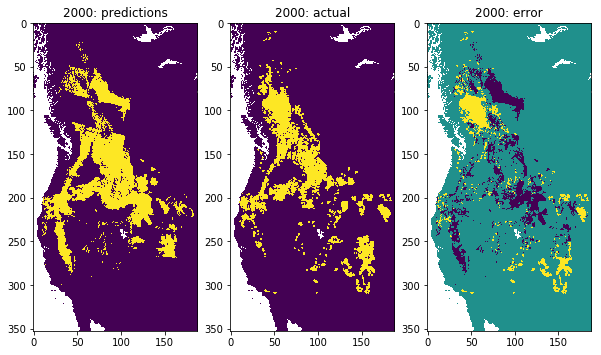

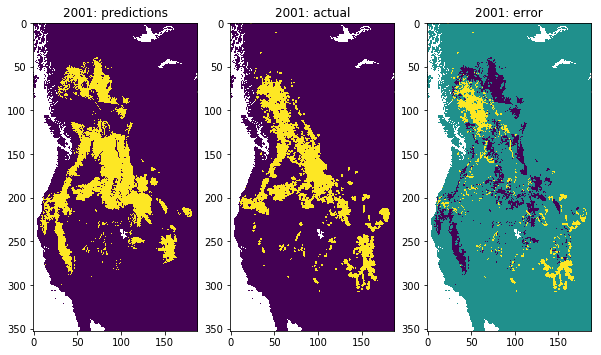

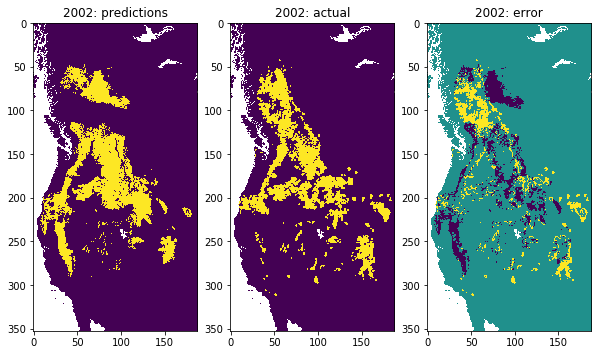

In [69]:
for year in X_test_full.year.unique():
    ms = get_pred_actual_error_matrices(year)
    plt.figure();
    pred_plots(ms, year)

# Random Forest

In [59]:
grid = GridSearchCV(
    estimator = RandomForestClassifier(random_state=1103),
    param_grid = [{'n_estimators': [16, 32, 64],
                   'max_depth': [16, 32, 64],
                   'min_samples_split': [2, 5, 10],
                   'min_samples_leaf': [2, 4, 8]}],
    cv=3,
    n_jobs=-1)

In [63]:
t0 = time.time()
grid.fit(X_tv, y_tv)
print((time.time() - t0) / 60)

221.1790558854739


In [61]:
print(grid.best_params_)

{'max_depth': 16, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 64}


In [62]:
!say "at last, my work is done!"

In [65]:
tree = grid.best_estimator_
tree.fit(X_tv, y_tv)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=4,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=64, n_jobs=1, oob_score=False, random_state=1103,
            verbose=0, warm_start=False)

In [89]:
preds = tree.predict(X_test)
preds_actual = pd.DataFrame({'preds': preds, 'actual': y_test})
preds_actual.head()

,actual,preds
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [90]:
preds = tree.predict(X_test)
preds_actual = pd.DataFrame({'preds': preds, 'actual': y_test})
preds_actual.head()

,actual,preds
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [91]:
cm = get_confusion_matrix(preds_actual.preds, preds_actual.actual, True)

            Actual
                  1|    0
             ------------
Predicted 1 | 14131|10809
          ---------------
          0 |  8184|143417

Accuracy:  0.8924 ± 0.0007
Recall:    0.6333 ± 0.0032
Precision: 0.5666 ± 0.0031
F1:        0.5981 ± 0.0032


In [92]:
feat_importance = pd.DataFrame({'predictor': predictors, 
                                'importance': tree.feature_importances_})
feat_importance = feat_importance.sort_values('importance', 
                                              ascending=False)
feat_importance

,importance,predictor
16,0.095314,lat
35,0.080464,lat:lon
28,0.072252,precip_OctSep:elev_etopo1
17,0.072166,lon
10,0.066915,vegetation
36,0.054233,lat:elev_etopo1
9,0.051589,precip_JunAug
15,0.038730,elev_etopo1
22,0.033956,precip_OctSep:lon
11,0.025489,precipPrevious_JunAug
